In [64]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import wandb
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from scipy.ndimage import gaussian_filter1d
from torch.utils.data import DataLoader
from bachelors_thesis.modeling.datasets.sigloc_dataset import SigLocDataset
from bachelors_thesis.modeling.sigloc import SigLoc12, SigLocNolan
from bachelors_thesis.utils import apply_preprocessors, plot_saliency, plot_ecg, PRECORDIAL_LEAD_NAMES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
project_path = "nateml-maastricht-university/bachelors-thesis"
run_id = "j8bdg20p"
artifact_name = "15_sigloc-nolan_resnet_best"
device = "cpu"  # Change to "cuda" if you have a GPU available

In [14]:
# Load the torch model from wandb
api = wandb.Api()
artifact = api.artifact(f"{project_path}/{artifact_name}:best")
artifact_path = artifact.download()

run = api.run(f"{project_path}/{run_id}")
config = dict(run.config)

# Convert config to omegaconf
cfg = OmegaConf.create(config)
cfg.model.context_encoder.enabled = True

# Load the model
checkpoint = torch.load(artifact_path + f"/{artifact_name}.pth", map_location=torch.device(device))

# Cast the model to the correct type
model = SigLocNolan(cfg.model)
model.to(device)
model.load_state_dict(checkpoint)
model.eval()

wandb:   1 of 1 files downloaded.  


SigLocNolan(
  (local_encoder): InceptionEncoderWithRes(
    (residual_proj): Sequential(
      (0): Conv1d(1, 144, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (pre_skip): Sequential(
      (0): InceptionBlock(
        (branch1): Sequential(
          (0): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (branch2): Sequential(
          (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
        (branch3): Sequential(
          (0): Conv1d(1

In [15]:
for name, module in model.local_encoder.pre_skip.named_modules():
    if isinstance(module, nn.Conv1d) and name.startswith("0."):
        print(name, module)

0.branch1.0 Conv1d(1, 16, kernel_size=(1,), stride=(1,))
0.branch2.0 Conv1d(1, 32, kernel_size=(1,), stride=(1,))
0.branch2.3 Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
0.branch3.0 Conv1d(1, 32, kernel_size=(1,), stride=(1,))
0.branch3.3 Conv1d(32, 32, kernel_size=(11,), stride=(1,), padding=(5,))
0.branch4.0 Conv1d(1, 32, kernel_size=(1,), stride=(1,))
0.branch4.3 Conv1d(32, 32, kernel_size=(41,), stride=(1,), padding=(20,))
0.branch5.1 Conv1d(1, 32, kernel_size=(1,), stride=(1,))


In [16]:
import ast

# Load the validation data
val_data = np.load('../../data/processed/ptbxl100all/val.npy')
meta = pd.read_csv('../../data/processed/ptbxl100all/meta_val.csv')

# Convert scp code strings to dictionaries
meta['scp_codes'] = meta['scp_codes'].apply(lambda x: ast.literal_eval(x))

THRESHOLD = 0.5
def codes_above_threshold(code_dict, thr=THRESHOLD):
    return {code for code, prob in code_dict.items() if prob >= thr}

meta["present_codes"] = meta["scp_codes"].apply(codes_above_threshold)

print(val_data.shape)
print(meta.shape)

(2183, 1000, 6)
(2183, 31)


In [17]:
# Preprocess the data
val_data_filtered = apply_preprocessors(val_data, cfg.dataset.sampling_rate, cfg.preprocessor_group.preprocessors)

In [18]:
# Convert to torch tensors
val_data_tensor = torch.tensor(val_data_filtered, dtype=torch.float32).to(device)

In [19]:
# Permute to (batch_size, channels, seq_len)
val_data_tensor = val_data_tensor.permute(0, 2, 1)

In [20]:
val_data_tensor[0, 0].unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 1000])

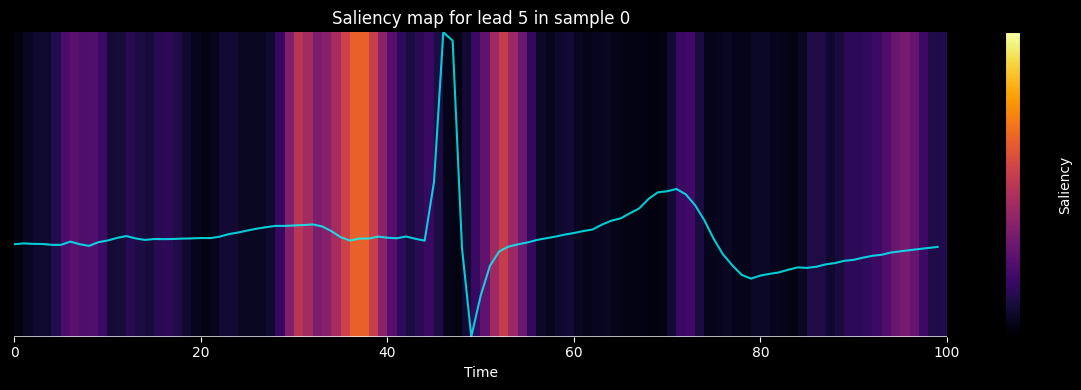

In [21]:
sample = 0

time_window = (0, 100)

x = val_data_tensor[sample].unsqueeze(0)
x.requires_grad = True

output = model(x)[1][0]
lead = 5
output = output[lead]

target_idx = output.argmax()
target = output[target_idx]

target.backward()

saliency = x.grad.data.abs()[0, lead].cpu().numpy()
saliency = saliency / saliency.max()
saliency = saliency[time_window[0]:time_window[1]]
saliency_smooth = gaussian_filter1d(saliency, sigma=1)
saliency_2d = saliency_smooth[np.newaxis, :]

ecg = x[0, lead].cpu().detach().numpy()
ecg = ecg[time_window[0]:time_window[1]]
ecg_scaled = (ecg - ecg.min()) / (ecg.max() - ecg.min())

fig, ax = plt.subplots(figsize=(12, 4))

ax.imshow(saliency_2d,
          cmap='inferno',
          aspect='auto',
          extent=[0, len(ecg), 0, 1],
          norm=plt.Normalize(vmin=0.01, vmax=saliency.max()))
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
cbar.set_label('Saliency', color='white')
ax.plot(np.arange(len(ecg)), ecg_scaled, color='cyan', linewidth=1.5, linestyle='-', label='ECG', alpha=0.8)
ax.set_title(f"Saliency map for lead {lead} in sample {sample}")
ax.set_yticks([])
ax.set_xlabel('Time')
# Set axis labels and ticks to white
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')
ax.set_facecolor('black')
ax.grid(False)
ax.axhline(y=0, color='white', linewidth=2, alpha=0.8)
for spine in ax.spines.values():
    spine.set_visible(False)
fig.patch.set_facecolor('black')
plt.tight_layout()
plt.show()

In [22]:
sample = 0
time_window = (0, 200)

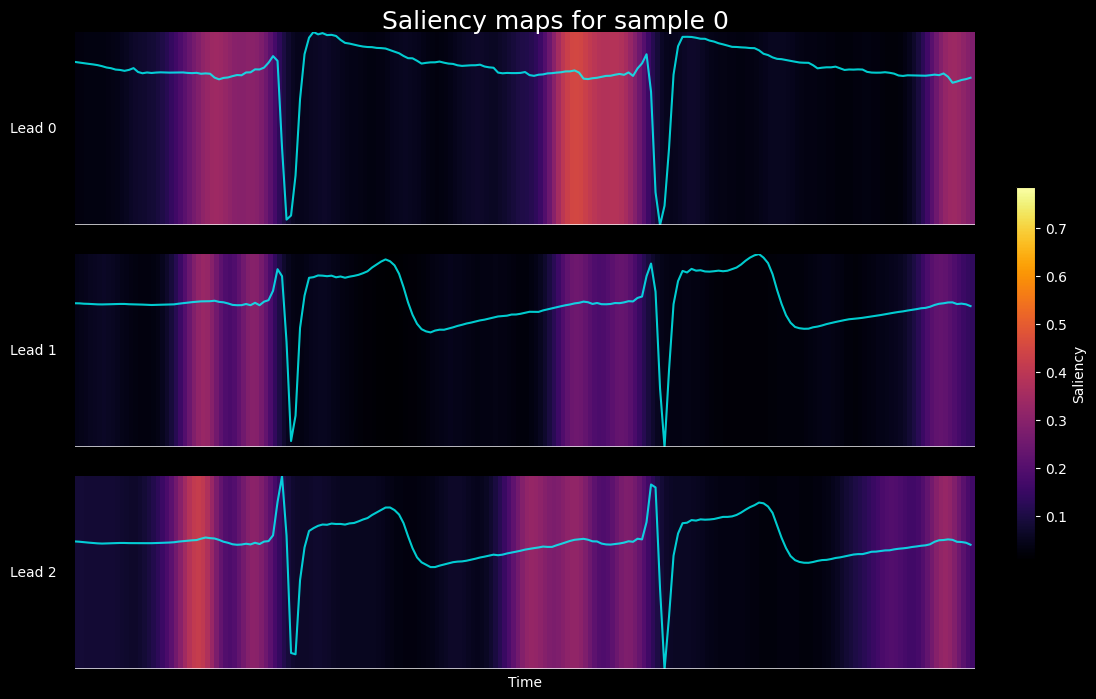

In [23]:
lead_indices = [0, 1, 2]  # define the leads you want to visualize

x = val_data_tensor[sample].unsqueeze(0)  # shape [1, L, T]
x.requires_grad = True

# Get output and select the classification head output
output = model(x)[1][0]  # [num_leads, num_classes]

# Create subplots
num_leads = len(lead_indices)
fig, axes = plt.subplots(num_leads, 1, figsize=(12, 2.5 * num_leads), sharex=True,
                         gridspec_kw={'hspace': 0.15})

for i, lead in enumerate(lead_indices):
    lead_output = output[lead]
    target_idx = lead_output.argmax()
    target = lead_output[target_idx]

    model.zero_grad()
    x.grad = None
    target.backward(retain_graph=True)

    saliency = x.grad.data.abs()[0, lead].cpu().numpy()
    saliency = saliency / saliency.max()
    saliency = saliency[time_window[0]:time_window[1]]
    saliency_smooth = gaussian_filter1d(saliency, sigma=3)
    saliency_2d = saliency_smooth[np.newaxis, :]

    ecg = x[0, lead].cpu().detach().numpy()
    ecg = ecg[time_window[0]:time_window[1]]
    ecg_scaled = (ecg - ecg.min()) / (ecg.max() - ecg.min())

    ax = axes[i] if num_leads > 1 else axes
    im = ax.imshow(saliency_2d,
                   cmap='inferno',
                   aspect='auto',
                   extent=[0, len(ecg), 0, 1],
                   norm=plt.Normalize(vmin=0.01, vmax=saliency.max()))

    ax.plot(np.arange(len(ecg)), ecg_scaled, color='cyan', linewidth=1.5, linestyle='-', alpha=0.8)

    # Minimal labeling
    ax.set_yticks([])
    ax.set_ylabel(f"Lead {lead}", color='white', rotation=0, labelpad=30, fontsize=10, va='center')
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    ax.axhline(y=0, color='white', linewidth=2, alpha=0.8)

    # Clean borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Hide x-ticks on all but last subplot
    if i < num_leads - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Time', color='white')

# Add a single colorbar to the side
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('Saliency', color='white')
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(cbar.ax.get_yticklabels(), color='white')

# Title for the whole figure
fig.suptitle(f'Saliency maps for sample {sample}', color='white', fontsize=18)
fig.patch.set_facecolor('black')

#plt.tight_layout(rect=[0, 0, 0.97, 0.90])
plt.subplots_adjust(left=0.1, right=0.85, top=0.95, bottom=0.1)
plt.show()

In [25]:
# Create a dataloader for the validation data
dataset = SigLocDataset(val_data_tensor)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
logits = np.zeros((len(dataset), 6, 6))
for idx, batch in enumerate(dataloader):
    # Move the batch to the GPU
    batch = batch.to(device)

    if idx == 0:
        print(batch.shape)
    
    # Make predictions
    with torch.no_grad():
        _, these_logits = model(batch)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()

logits.shape

torch.Size([64, 6, 1000])


(2183, 6, 6)

In [155]:
# Get indices of correct predictions
correct = np.all(np.argmax(logits, axis=2) == np.arange(6), axis=1).reshape(1, -1)
correct_indices = np.where(correct)[1]
wrong_indices = np.where(~correct)[1]
print(len(correct_indices), len(wrong_indices))

1906 277


In [27]:
list(model.local_encoder.pre_skip.named_modules())

[('',
  Sequential(
    (0): InceptionBlock(
      (branch1): Sequential(
        (0): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (branch2): Sequential(
        (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (branch3): Sequential(
        (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(32, 32, kernel_size=(11,), stride=(1,), padding=(5,))
        (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [28]:
pat = re.compile(r"\d+\.branch[1-5]$")
for name, module in model.local_encoder.pre_skip.named_modules():
    if pat.match(name) and name.startswith("0."):
        print(name)
        print(module)

0.branch1
Sequential(
  (0): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)
0.branch2
Sequential(
  (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
)
0.branch3
Sequential(
  (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv1d(32, 32, kernel_size=(11,), stride=(1,), padding=(5,))
  (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
)
0.branch4
Sequential(
  (0): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=Tru

In [29]:
# Register a forward hook to capture activations
activations = {}
hooks = []

def make_hook_fn(name):
    def hook_fn(module, input, output):
        activations[name] = output.detach()
    return hook_fn

num = 0
pat = re.compile(r"\d+\.branch[1-5]$")
for name, module in model.local_encoder.pre_skip.named_modules():
    if pat.match(name) and name.startswith("4."):
        hook_fn = make_hook_fn(f"{name}")
        hook = module.register_forward_hook(hook_fn)
        hooks.append(hook)
        print(f"Registered hook for {name}")
        num += 1

sample = 0
with torch.no_grad():
    x = val_data_tensor[sample].unsqueeze(0)
    _ = model(x)

# Unregister hooks
for hook in hooks:
    hook.remove()

Registered hook for 4.branch1
Registered hook for 4.branch2
Registered hook for 4.branch3
Registered hook for 4.branch4
Registered hook for 4.branch5


In [30]:
activations.keys()

dict_keys(['4.branch1', '4.branch2', '4.branch3', '4.branch4', '4.branch5'])

In [31]:
# Remove activations that are not needed
try:
    #del activations['0.branch1.0']
    del activations['2.branch2.0']
    del activations['2.branch3.0']
    del activations['2.branch4.0']
except KeyError:
    pass

In [32]:
kernel_sizes = {
    name: f"Activation for branch {name[-1]} (kernel size " + str([sub for sub in module if isinstance(sub, nn.Conv1d)][-1].kernel_size[0]) + "x1)"
    for name, module in model.local_encoder.pre_skip.named_modules()
    if re.match(pat, name)
}
kernel_sizes

{'0.branch1': 'Activation for branch 1 (kernel size 1x1)',
 '0.branch2': 'Activation for branch 2 (kernel size 5x1)',
 '0.branch3': 'Activation for branch 3 (kernel size 11x1)',
 '0.branch4': 'Activation for branch 4 (kernel size 41x1)',
 '0.branch5': 'Activation for branch 5 (kernel size 1x1)',
 '2.branch1': 'Activation for branch 1 (kernel size 1x1)',
 '2.branch2': 'Activation for branch 2 (kernel size 5x1)',
 '2.branch3': 'Activation for branch 3 (kernel size 11x1)',
 '2.branch4': 'Activation for branch 4 (kernel size 41x1)',
 '2.branch5': 'Activation for branch 5 (kernel size 1x1)',
 '4.branch1': 'Activation for branch 1 (kernel size 1x1)',
 '4.branch2': 'Activation for branch 2 (kernel size 5x1)',
 '4.branch3': 'Activation for branch 3 (kernel size 11x1)',
 '4.branch4': 'Activation for branch 4 (kernel size 41x1)',
 '4.branch5': 'Activation for branch 5 (kernel size 1x1)'}

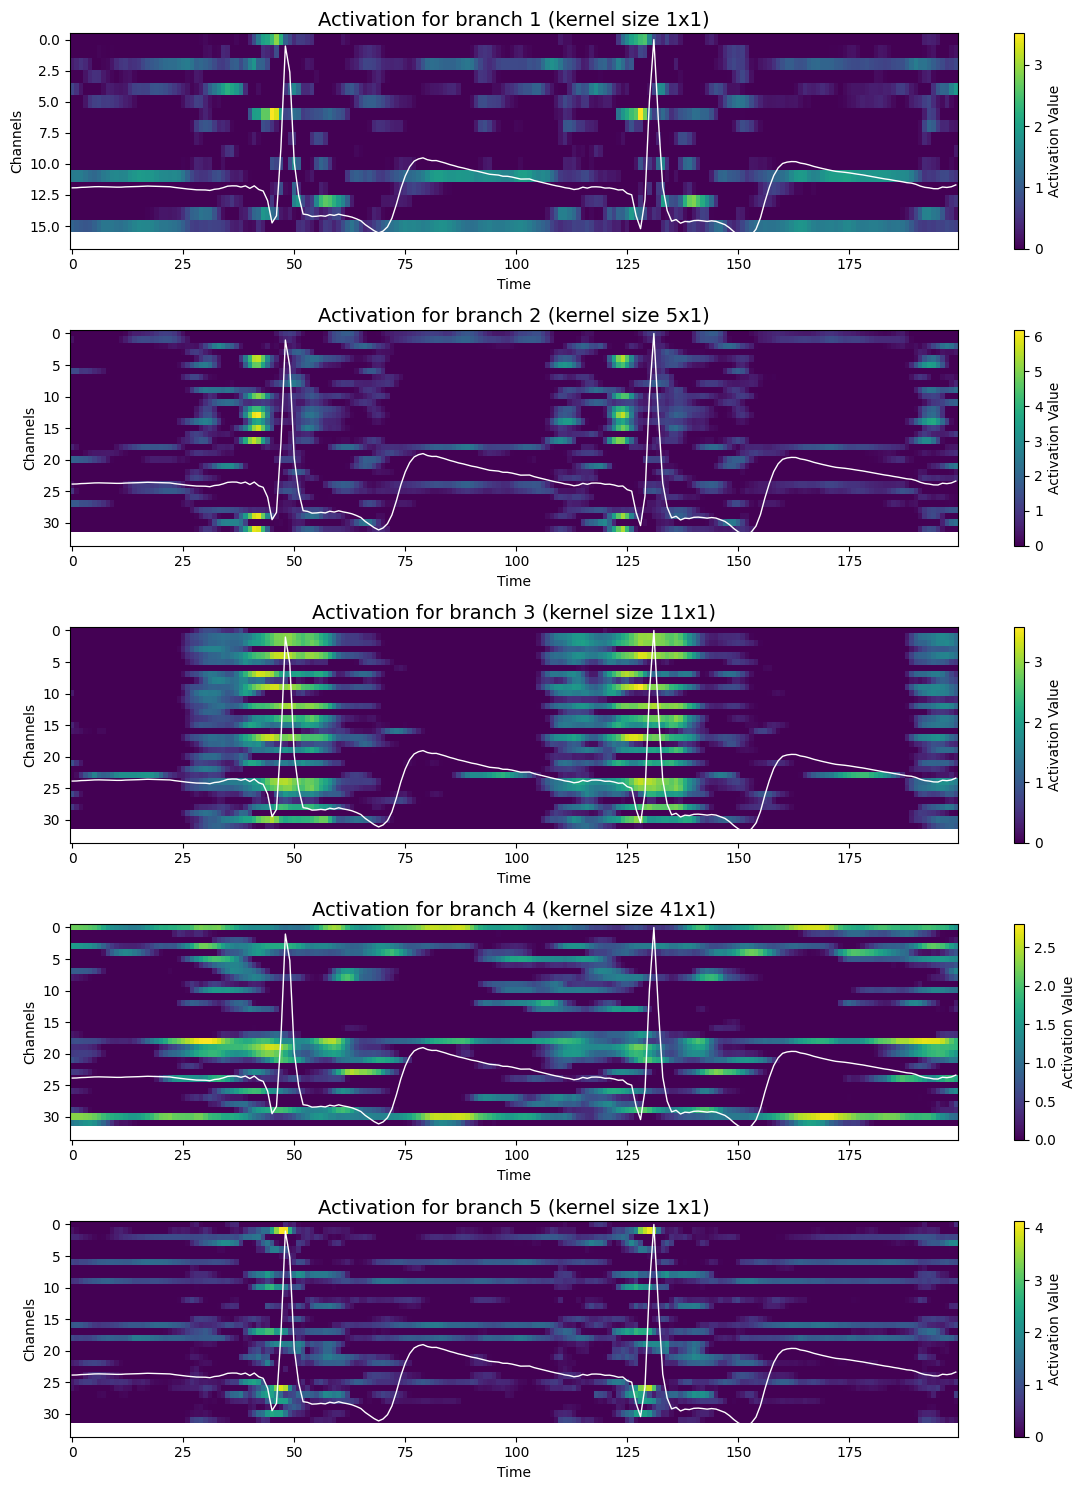

In [ ]:
time_window = (0, 200)

lead = 1
ecg_segment = val_data_tensor[sample, lead].cpu().numpy()[time_window[0]:time_window[1]]  # shape: [time]

# Sort keys to keep layers in order (e.g., conv0, conv2, ...)
#sorted_keys = sorted(activations.keys(), key=lambda x: int(x.replace('branch_', '')))

num_layers = len(activations.keys())
plt.figure(figsize=(12, 3 * num_layers))

for i, key in enumerate(activations.keys()):
    act = activations[key].cpu().numpy()[0]  # shape: [channels, time]
    act = act[:, time_window[0]:time_window[1]]  # Apply time window
    n_channels, n_time = act.shape

    # Normalize ECG to activation value range
    ecg_norm = (ecg_segment - ecg_segment.min()) / (ecg_segment.max() - ecg_segment.min())
    ecg_scaled = ecg_norm * n_channels  # scale to match heatmap y-axis

    plt.subplot(num_layers, 1, i + 1)
    plt.imshow(act, aspect='auto', cmap='viridis')
    plt.plot(np.arange(n_time), ecg_scaled, color='white', linewidth=1.0, label="ECG")
    plt.colorbar(label='Activation Value')
    plt.title(kernel_sizes[key], fontsize=14, color='black')
    plt.xlabel('Time')
    plt.ylabel('Channels')

plt.tight_layout()
plt.show()

In [80]:
# Calculate the sample with the most confident correct predictions
# We define "most confident" as the sample with the highest average confidence across all its correct predictions
max_logits = np.max(logits, axis=2)

In [81]:
# This basically represents how confident the model was in its predictions for each lead
max_logits[0]

array([10.62691212,  8.53994846,  8.94270134,  7.9992795 , 10.03694439,
        9.73228741])

In [85]:
# Find the sample with the highest average confidence
avg_confidence = max_logits.mean(axis=1)

# Order the predictions by their average confidence
idx_by_confidence = np.argsort(avg_confidence)[::-1]
print(idx_by_confidence)

[1036  729 1294 ...  567 1431 1433]


<Axes: title={'center': 'ECG signals array | sr=100 Hz'}, xlabel='Samples', ylabel='Leads'>

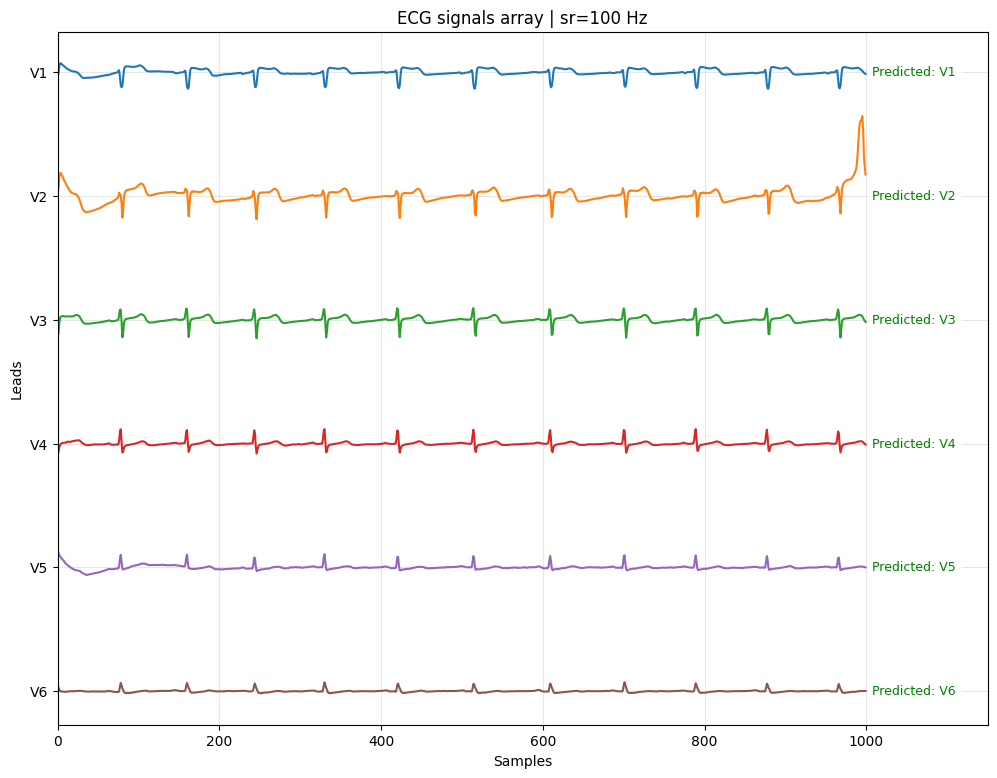

In [140]:
idx = idx_by_confidence[4]
signals = val_data_filtered[idx]
# Visualise
preds = np.argmax(logits[idx], axis=1)
str_predictions = np.asarray(PRECORDIAL_LEAD_NAMES)[preds]
plot_ecg(signals, sampling_rate=100, predictions=str_predictions)

In [105]:
# Convert to probabilities
logits_tensor = torch.from_numpy(logits)
probs = torch.softmax(logits_tensor, dim=2)
print(probs[idx].max(axis=1)[0].numpy())

[0.99999885 0.99981165 0.98594922 0.99979724 0.99787845 0.99986644]


In [114]:
val_data_tensor[idx][1, :].expand(1, -1)

tensor([[ 6.6225e-02,  4.2553e-02,  2.0601e-02,  1.2782e-02,  7.2689e-04,
         -6.5524e-03, -3.5323e-02, -4.1566e-02, -1.2301e-01, -1.9092e-01,
         -1.3192e-01, -8.8635e-02, -5.2279e-02, -1.7621e-02,  1.4406e-02,
          5.9260e-02,  9.1791e-02,  7.0627e-02,  3.5576e-02,  3.5831e-02,
          1.9656e-02,  2.1030e-02,  5.9304e-03,  9.2970e-03,  1.3346e-02,
          1.7051e-02,  4.2500e-02,  1.0613e-01,  4.7442e-01,  5.5875e-01,
          2.6075e-02, -6.8073e-01, -8.9106e-01, -3.3425e-01,  2.0481e-02,
          7.5640e-02,  1.2435e-01,  1.0458e-01,  1.1486e-01,  1.0385e-01,
          1.1453e-01,  1.1633e-01,  1.1188e-01,  1.1414e-01,  1.0338e-01,
          1.0464e-01,  1.1120e-01,  1.1590e-01,  1.2941e-01,  1.4140e-01,
          1.6056e-01,  1.9202e-01,  2.2510e-01,  2.4994e-01,  2.5461e-01,
          2.3780e-01,  2.0602e-01,  1.6918e-01,  9.4180e-02,  9.2213e-03,
         -6.7371e-02, -1.3025e-01, -1.7165e-01, -1.9887e-01, -2.0719e-01,
         -2.1435e-01, -2.1083e-01, -2.

In [117]:
val_data_tensor[idx][1, :].expand(1, -1).shape

torch.Size([1, 1000])

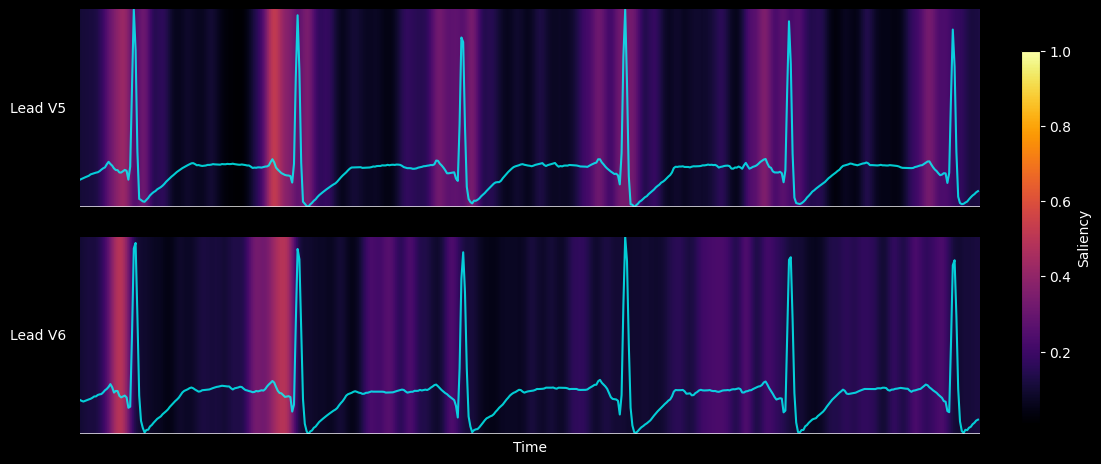

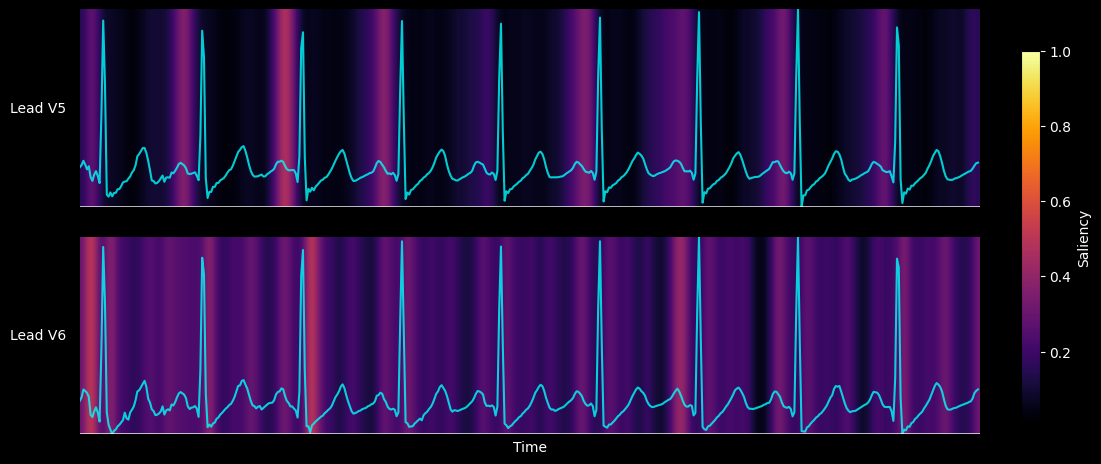

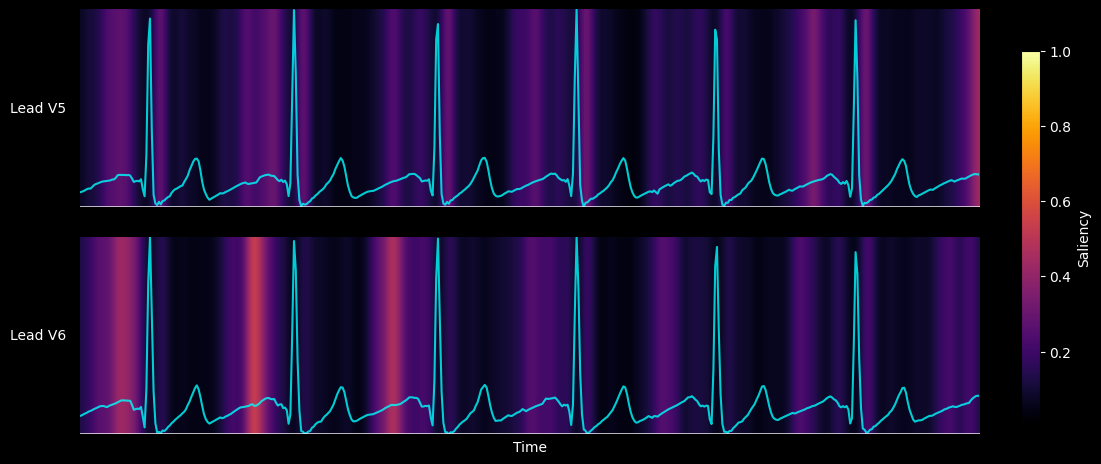

: 

In [ ]:
# Plot the saliency map for the most confident sample
leads = [4, 5]
for i in range(3):
    idx = idx_by_confidence[i]
    plot_saliency(model=model,
                signals=val_data_tensor[idx],
                lead_idx = leads,
                leads=np.asarray(PRECORDIAL_LEAD_NAMES)[leads] if len(leads) > 1 else np.asarray(PRECORDIAL_LEAD_NAMES)[leads[0]:leads[0]+1],
                title="",
                time_window=(0, 500))

In [159]:
# Find the most confident incorrect prediction
for i in idx_by_confidence:
    if i not in correct_indices:
        incorrect_pred_idx = i
        break

print(incorrect_pred_idx)
print(logits[incorrect_pred_idx])
print(logits[incorrect_pred_idx].argmax(axis=1))

1420
[[ 13.29450512   7.57765007   0.28967273  -4.79100418  -8.09106922
  -11.38119125]
 [  5.16242027  12.72569561   2.61064124  -4.89600515  -7.77705193
  -11.47193813]
 [ -0.64730567   4.08041954  13.45699215   0.08268964  -6.642591
   -3.23494434]
 [ -8.99936962  -2.95049787   0.4823029   10.28034306   2.58877468
    1.42821383]
 [ -9.17108059  -5.61639118  -4.46231079   0.04893535   9.41115856
   10.17014599]
 [ -5.494102    -4.76866531  -3.2586298   -0.40516442   6.46091986
   10.53637981]]
[0 1 2 3 5 5]


<Axes: title={'center': 'ECG signals array | sr=100 Hz'}, xlabel='Samples', ylabel='Leads'>

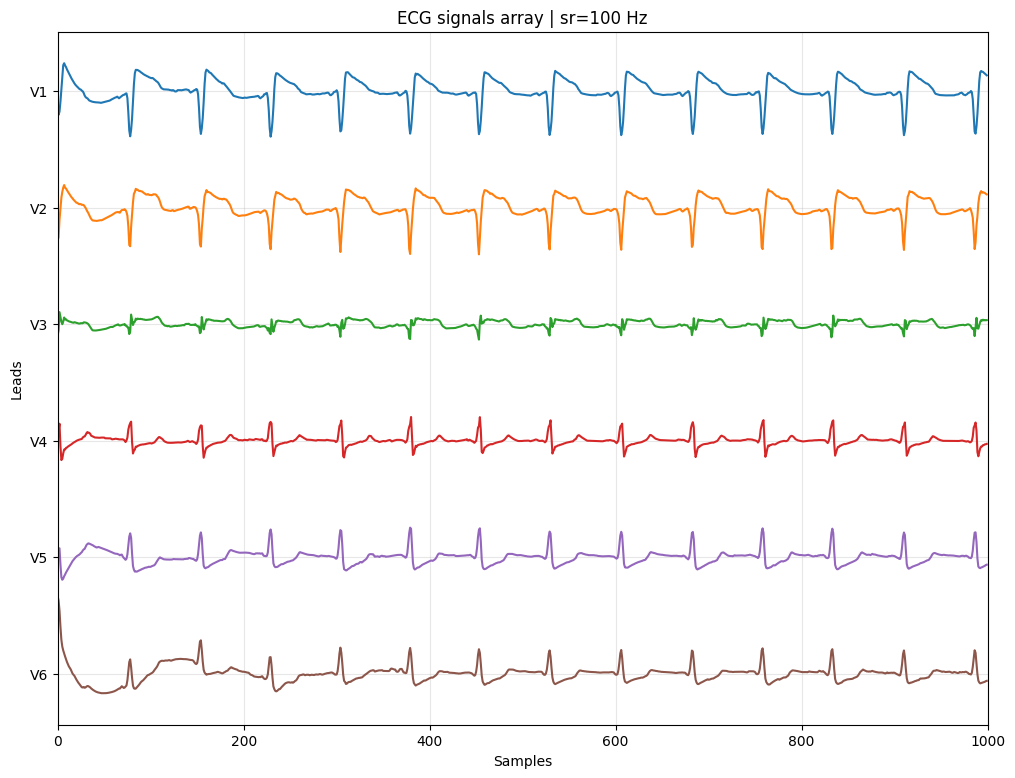

In [158]:
plot_ecg(
    val_data_filtered[incorrect_pred_idx]
)

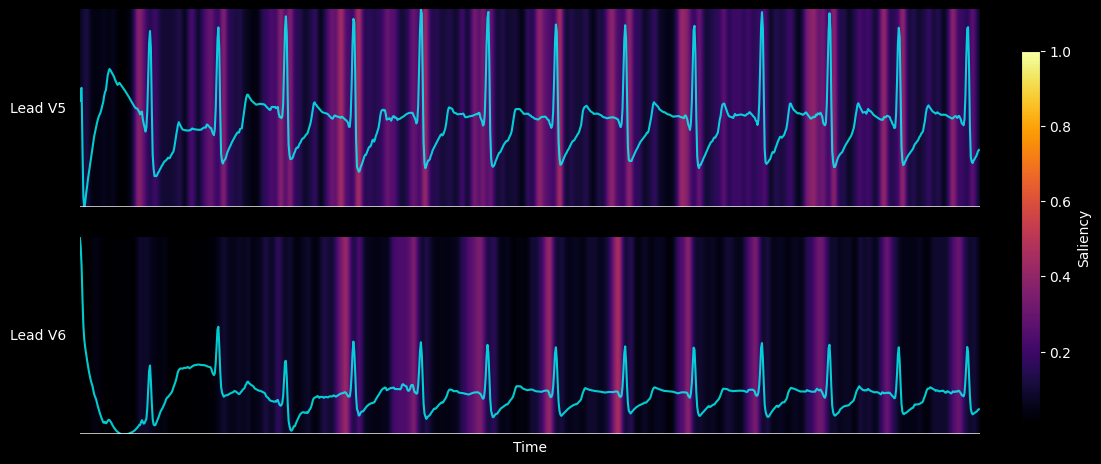

(<Figure size 1200x500 with 3 Axes>,
 array([<Axes: ylabel='Lead V5'>, <Axes: xlabel='Time', ylabel='Lead V6'>],
       dtype=object))

In [160]:
leads = [4, 5]
plot_saliency(model=model,
            signals=val_data_tensor[incorrect_pred_idx],
            lead_idx = leads,
            leads=np.asarray(PRECORDIAL_LEAD_NAMES)[leads] if len(leads) > 1 else np.asarray(PRECORDIAL_LEAD_NAMES)[leads[0]:leads[0]+1],
            title="",
            time_window=(0, 1000))